# Fraud Detection - Autoencoder (PyTorch Version)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


## Load Dataset

In [4]:
df = pd.read_csv("creditcard.csv")  # Upload this file manually in Colab
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Exploratory Data Analysis

Class
0    284315
1       492
Name: count, dtype: int64


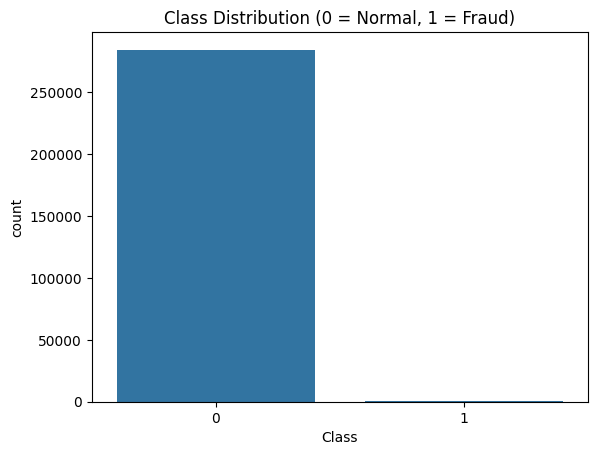

In [5]:
print(df['Class'].value_counts())
sns.countplot(data=df, x='Class')
plt.title('Class Distribution (0 = Normal, 1 = Fraud)')
plt.show()


## Data Preprocessing

In [6]:
X = df.drop(columns=['Class'])
y = df['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
X_train_norm = X_train[y_train == 0]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.int64)

train_loader = DataLoader(TensorDataset(X_train_tensor, X_train_tensor), batch_size=64, shuffle=True)


## Autoencoder Model in PyTorch

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

input_dim = X_train_tensor.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


## Train Model

In [8]:
num_epochs = 50
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_features, _ in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_features)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.6f}")


Epoch 1/50, Loss: 0.628618
Epoch 2/50, Loss: 0.544113
Epoch 3/50, Loss: 0.513707
Epoch 4/50, Loss: 0.500935
Epoch 5/50, Loss: 0.483361
Epoch 6/50, Loss: 0.475104
Epoch 7/50, Loss: 0.471709
Epoch 8/50, Loss: 0.470229
Epoch 9/50, Loss: 0.469750
Epoch 10/50, Loss: 0.468429
Epoch 11/50, Loss: 0.468228
Epoch 12/50, Loss: 0.468091
Epoch 13/50, Loss: 0.467613
Epoch 14/50, Loss: 0.465200
Epoch 15/50, Loss: 0.455357
Epoch 16/50, Loss: 0.446414
Epoch 17/50, Loss: 0.444138
Epoch 18/50, Loss: 0.442982
Epoch 19/50, Loss: 0.441751
Epoch 20/50, Loss: 0.440814
Epoch 21/50, Loss: 0.440710
Epoch 22/50, Loss: 0.440164
Epoch 23/50, Loss: 0.439510
Epoch 24/50, Loss: 0.438959
Epoch 25/50, Loss: 0.438801
Epoch 26/50, Loss: 0.438195
Epoch 27/50, Loss: 0.438257
Epoch 28/50, Loss: 0.437781
Epoch 29/50, Loss: 0.437124
Epoch 30/50, Loss: 0.437086
Epoch 31/50, Loss: 0.437102
Epoch 32/50, Loss: 0.436039
Epoch 33/50, Loss: 0.435818
Epoch 34/50, Loss: 0.423875
Epoch 35/50, Loss: 0.412262
Epoch 36/50, Loss: 0.409219
E

## Evaluate on Test Set

In [9]:
model.eval()
with torch.no_grad():
    X_test_pred = model(X_test_tensor)
    mse = torch.mean((X_test_tensor - X_test_pred) ** 2, dim=1).numpy()

threshold = np.percentile(mse, 95)
y_pred = (mse > threshold).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, mse))


Confusion Matrix:
[[54097  2767]
 [   16    82]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.03      0.84      0.06        98

    accuracy                           0.95     56962
   macro avg       0.51      0.89      0.52     56962
weighted avg       1.00      0.95      0.97     56962

ROC AUC: 0.9369166173785214


In [10]:
# Save the model (weights only)
torch.save(model.state_dict(), "autoencoder_model.pt")
print("Model saved to 'autoencoder_model.pt'")

# Save the scaler
import joblib
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved to 'scaler.pkl'")


Model saved to 'autoencoder_model.pt'
Scaler saved to 'scaler.pkl'
